## Posterior Predictive Checks

In this tutorial you will learn how to run posterior predictive checks in HDDM.

A posterior predictive check is a very useful tool when you want to evaluate if your model can reproduce key patterns in your data. Specifically, you can define a summary statistic that describes the pattern you are interested in (e.g. accuracy in your task) and then simulate new data from the posterior of your fitted model. You can the apply the the summary statistic to each of the data sets you simulated from the posterior and see if the model does a good job of reproducing this pattern by comparing the summary statistics from the simulations to the summary statistic caluclated over the model.

What is critical is that you do not only get a single summary statistic from the simulations but a whole distribution which captures the uncertainty in our model estimate.

Lets do a simple analysis using simulated data. First, import HDDM.

In [3]:
import hddm
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

Simulate data from known parameters and two conditions (easy and hard).

In [4]:
data, params = hddm.generate.gen_rand_data(
    params={"easy": {"v": 1, "a": 2, "t": 0.3}, "hard": {"v": 1, "a": 2, "t": 0.3}}
)

First, lets estimate the same model that was used to generate the data.

In [5]:
m = hddm.HDDM(data, depends_on={"v": "condition"})
m.sample(1000, burn=20)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1000 of 1000 complete in 12.5 sec

Next, we'll want to simulate data from the model. By default, `post_pred_gen()` will use 500 parameter values from the posterior (i.e. posterior samples) and simulate a different data set for each parameter value.

In [6]:
print(m.nodes_db)

           knode_name stochastic observed   subj        node      tag  \
a                   a       True    False  False           a       ()   
v(easy)             v       True    False  False     v(easy)  (easy,)   
v(hard)             v       True    False  False     v(hard)  (hard,)   
t                   t       True    False  False           t       ()   
wfpt(easy)       wfpt      False     True  False  wfpt(easy)  (easy,)   
wfpt(hard)       wfpt      False     True  False  wfpt(hard)  (hard,)   

                depends hidden   rt response subj_idx condition      mean  \
a                    []  False  NaN      NaN      NaN       NaN   1.90643   
v(easy)     [condition]  False  NaN      NaN      NaN      easy   1.06179   
v(hard)     [condition]  False  NaN      NaN      NaN      hard  0.943137   
t                    []  False  NaN      NaN      NaN       NaN  0.341715   
wfpt(easy)  [condition]  False  NaN      NaN      NaN      easy       NaN   
wfpt(hard)  [condition]  F

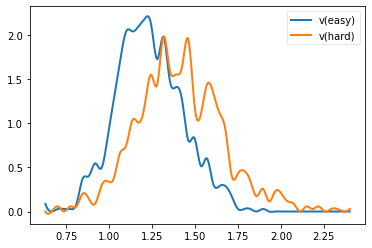

In [34]:
hddm.analyze.plot_posterior_nodes(m.nodes_db.loc[["v(easy)", "v(hard)"], "node"])

In [35]:
ppc_data = hddm.utils.post_pred_gen(m)

 [--------------------------150%---------------------------] 3 of 2 complete in 5.9 sec

In [36]:
hddm.utils.post_pred_stats(data, ppc_data)

,observed,mean,std,SEM,MSE,credible,quantile,mahalanobis
stat,,,,,,,,
accuracy,0.910000,0.927500,0.050637,0.000306,0.002870,True,31.500000,0.345593
mean_ub,0.935440,0.951484,0.098785,0.000257,0.010016,True,46.400002,0.162416
std_ub,0.421473,0.464852,0.111991,0.001882,0.014424,True,37.700001,0.387345
10q_ub,0.501000,0.521309,0.039991,0.000412,0.002012,True,32.200001,0.507850
30q_ub,0.686000,0.658764,0.057687,0.000742,0.004070,True,71.500000,0.472135
50q_ub,0.832000,0.820630,0.088531,0.000129,0.007967,True,59.900002,0.128429
70q_ub,1.008000,1.053636,0.134238,0.002083,0.020102,True,40.200001,0.339962
90q_ub,1.573000,1.542863,0.247801,0.000908,0.062314,True,59.599998,0.121618
mean_lb,-1.049667,-0.990737,0.350941,0.003473,0.126632,True,33.798283,0.167918


The returned data structure is a pandas `DataFrame` object with a hierarchical index.

In [37]:
ppc_data.head(10)

rt  response
node       sample                      
wfpt(easy) 0      0  0.481109         1
                  1  0.755106         1
                  2  0.713106         1
                  3  1.100101         1
                  4  0.905104         1
                  5  0.716106         1
                  6 -0.873104         0
                  7  0.404109         1
                  8  1.566114         1
                  9  1.419107         1

The first level of the `DataFrame` contains each observed node. In this case the easy condition. If we had multiple subjects we would get one for each subject.

The second level contains the simulated data sets. Since we simulated 500, these will go from 0 to 499 -- each with generated from a different parameter value sampled from the posterior.

The third level is the same index as used in the data and numbers each trial in your data.

For more information on how to work with hierarchical indices, see the [Pandas documentation](http://pandas.pydata.org/pandas-docs/stable/indexing.html#hierarchical-indexing-multiindex).

There are also some helpful options like `append_data` you can pass to `post_pred_gen()`.

In [38]:
help(hddm.utils.post_pred_gen)

Help on function post_pred_gen in module kabuki.analyze:

post_pred_gen(model, groupby=None, samples=500, append_data=False, add_model_parameters=False, progress_bar=True)
    Run posterior predictive check on a model.
    
    :Arguments:
        model : kabuki.Hierarchical
            Kabuki model over which to compute the ppc on.
    
    :Optional:
        samples : int
            How many samples to generate for each node.
        groupby : list
            Alternative grouping of the data. If not supplied, uses splitting
            of the model (as provided by depends_on).
        append_data : bool (default=False)
            Whether to append the observed data of each node to the replicatons.
        progress_bar : bool (default=True)
            Display progress bar
    
    :Returns:
        Hierarchical pandas.DataFrame with multiple sampled RT data sets.
        1st level: wfpt node
        2nd level: posterior predictive sample
        3rd level: original data index
    

Now we want to compute the summary statistics over each simulated data set and compare that to the summary statistic of our actual data by calling `post_pred_stats()`.

In [39]:
ppc_compare = hddm.utils.post_pred_stats(data, ppc_data)

In [42]:
print(ppc_compare)

          observed      mean       std       SEM       MSE credible  \
stat                                                                  
accuracy  0.910000  0.927500  0.050637  0.000306  0.002870     True   
mean_ub   0.935440  0.951484  0.098785  0.000257  0.010016     True   
std_ub    0.421473  0.464852  0.111991  0.001882  0.014424     True   
10q_ub    0.501000  0.521309  0.039991  0.000412  0.002012     True   
30q_ub    0.686000  0.658764  0.057687  0.000742  0.004070     True   
50q_ub    0.832000  0.820630  0.088531  0.000129  0.007967     True   
70q_ub    1.008000  1.053636  0.134238  0.002083  0.020102     True   
90q_ub    1.573000  1.542863  0.247801  0.000908  0.062314     True   
mean_lb  -1.049667 -0.990737  0.350941  0.003473  0.126632     True   
std_lb    0.430255  0.297619  0.251784  0.017592  0.080988     True   
10q_lb    0.491400  0.726807  0.332695  0.055416  0.166103     True   
30q_lb    0.799600  0.819943  0.335312  0.000414  0.112848     True   
50q_lb

As you can see, we did not have to define the summary statistics as by default, `HDDM` already calculates a bunch of useful statistics for RT analysis such as the accuracy, mean RT of the upper and lower boundary (ub and lb respectively), standard deviation and quantiles. These are listed in the rows of the DataFrame.

For each distribution of summary statistics there are multiple ways to compare them to the summary statistic obtained on the observerd data. These are listed in the columns. `observed` is just the value of the summary statistic of your data. `mean` is the mean of the summary statistics of the simulated data sets (they should be a good match if the model reproduces them). `std` is a measure of how much variation is produced in the summary statistic.

The rest of the columns are measures of how far the summary statistic of the data is away from the summary statistics of the simulated data. `SEM` = standard error from the mean, `MSE` = mean-squared error, `credible` = in the 95% credible interval.

Finally, we can also tell `post_pred_stats()` to return the summary statistics themselves by setting `call_compare=False`:

In [43]:
ppc_stats = hddm.utils.post_pred_stats(data, ppc_data, call_compare=False)

In [44]:
print(ppc_stats.head())

                   accuracy   mean_ub    std_ub    10q_ub    30q_ub    50q_ub  \
node       sample                                                               
wfpt(easy) 0           0.86  1.062849  0.724248  0.484509  0.667707  0.905104   
           1           0.98  0.977835  0.474633  0.498661  0.680059  0.882057   
           2           0.82  0.996223  0.515579  0.555150  0.671149  0.817147   
           3           0.88  0.875679  0.305067  0.510363  0.733061  0.835860   
           4           0.92  0.815038  0.503699  0.510257  0.593757  0.626257   

                     70q_ub    90q_ub   mean_lb    std_lb    10q_lb    30q_lb  \
node       sample                                                               
wfpt(easy) 0       1.078501  1.749323 -1.398971  0.610027  0.740706  1.084301   
           1       1.133453  1.642467 -0.624060  0.000000  0.624060  0.624060   
           2       1.004145  1.785162 -1.002371  0.407241  0.611750  0.756748   
           3       0.951658

This `DataFrame` has a row for each simulated data set. The columns are the different summary statistics.

### Using PPC for model comparison with the `groupby` argument

One useful application of PPC is to perform model
comparison. Specifically, you might estimate two models, one for which
a certain parameter is split for a condition (say drift-rate ``v`` for
hard and easy conditions to stay with our example above) and one in
which those conditions are pooled and you only estimate one
drift-rate.

You then want to test which model explains the data better to assess
whether the two conditions are really different. To do this, we can
generate data from both models and see if the pooled model
systematically misses aspects of the RT data of the two
conditions. This is what the ``groupby`` keyword argument is
for. Without it, if you ran ``post_pred_gen()`` on the pooled model
you would get simulated RT data which was not split by
conditions. Note that while the RT data will be split by condition,
the exact same parameters are used to simulate data of the two
conditions as the pooled model does not separate them. It simply
allows us to match the two conditions present in the data to the
jointly simulated data more easily.

In [ ]:
m_pooled = hddm.HDDM(data)  # v does not depend on conditions
m_pooled.sample(1000, burn=20)
ppc_data_pooled = hddm.utils.post_pred_gen(m_pooled, groupby=["condition"])

You could then compare ``ppc_data_pooled`` to ``ppc_data`` above (by
passing them to ``post_pred_stats``) and find that the model with
separate drift-rates accounts for accuracy (``mean_ub``) in both
conditions, while the pooled model can't account for accuracy in
either condition (e.g. lower ``MSE``).

### Defining your own summary statistics

You can also define your own summary statistics and pass them to `post_pred_stats()`:

In [45]:
ppc_stats = hddm.utils.post_pred_stats(
    data, ppc_data, stats=lambda x: np.mean(x), call_compare=False
)

In [46]:
ppc_stats.head()

stat
node       sample          
wfpt(easy) 0       0.718194
           1       0.945797
           2       0.636476
           3       0.659214
           4       0.664474

Note that `stats` can also be a dictionary mapping the name of the summary statistic to its function.

### Summary statistics relating to outside variables

Another useful way to apply posterior predictive checks is if you have trial-by-trial measure (e.g. EEG brain measure). In that case the `append_data` keyword argument is useful.

Lets add a dummy column to our data. This is going to be uncorrelated to anything but you'll get the idea.

In [47]:
from numpy.random import randn

data["trlbytrl"] = randn(len(data))

In [48]:
m_reg = hddm.HDDMRegressor(data, "v ~ trlbytrl")
m_reg.sample(1000, burn=20)

ppc_data = hddm.utils.post_pred_gen(m_reg, append_data=True)

No model attribute --> setting up standard HDDM
Set model to ddm
 [-----------------100%-----------------] 1 of 1 complete in 0.0 sec1.4 sec

In [49]:
from scipy.stats import linregress

ppc_regression = []
for (node, sample), sim_data in ppc_data.groupby(level=(0, 1)):
    ppc_regression.append(
        linregress(sim_data.trlbytrl, sim_data.rt_sampled)[0]
    )  # slope

orig_regression = linregress(data.trlbytrl, data.rt)[0]

In [54]:
cnt = 0
for (node, sample), sim_data in ppc_data.groupby(level=(0, 1)):
    print(sim_data)
    cnt += 1
    if cnt > 2:
        break

                rt_sampled  response_sampled  index     rt  response  \
node sample                                                            
wfpt 0      0     1.121020                 1      0  0.934       1.0   
            1     0.487028                 1      1  0.802       1.0   
            2     1.383025                 1      2  1.394       1.0   
            3     0.762025                 1      3  1.213       1.0   
            4     1.609036                 1      4 -1.434       0.0   
...                    ...               ...    ...    ...       ...   
            95    0.717025                 1     95  1.015       1.0   
            96    0.711025                 1     96  0.827       1.0   
            97    0.805024                 1     97  0.468       1.0   
            98    1.552033                 1     98 -0.612       0.0   
            99    0.672026                 1     99  1.138       1.0   

                subj_idx condition  trlbytrl  
node sample     

Text(0.5, 0, 'slope')

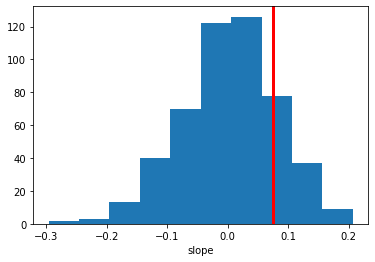

In [50]:
plt.hist(ppc_regression)
plt.axvline(orig_regression, c="r", lw=3)
plt.xlabel("slope")

As you can see, the simulated data sets have on average no correlation to our trial-by-trial measure (just as in the data) but we also get a nice sense of the uncertainty in our estimation.